# XGBoost

* Performs xgboost on training data. 
* Iterates over parameters with cross validation
* Currently ignoring date parameters due to large number of factors. Waiting for preprocessing steps to improve. 
* Warning: takes a long time to cross validate

In [15]:
# Libraries
library(xgboost)
library(dplyr)
library(Matrix)
library(data.table)
library(Ckmeans.1d.dp)
library(e1071)
library(caret)

# Set Seed
set.seed(1066)

# Name of Run
NAME <- "FE_1"

** Currently remove date features because of large number of factors **  

In [16]:
# Read data
# remove id and date_first_booking as they are not relevant
# CURRENTLY REMOVES DATE PARAMETERS AS WELL
dat_raw <- readRDS("../Data/users_PP.RDS") %>%
    na.omit()

dat <- dat_raw %>%
    select(-c(id,dataset,age_cln,age_cln2)) %>%
    data.table(keep.rownames = F)

In [17]:
# One-hot encoding  
# https://cran.r-project.org/web/packages/xgboost/vignettes/discoverYourData.html
sparse_dat <- sparse.model.matrix(country_destination ~ . -1, data = dat)

# Find the training set
sparse_tr <- sparse_dat[dat_raw$dataset == "train",]
tr <- dat[dat_raw$dataset == "train",]

In [18]:
# Parameter search using Cross validation
# http://stats.stackexchange.com/questions/171043/how-to-tune-hyperparameters-of-xgboost-trees
# Currently using low number of rounds to test

# set up the cross-validated hyper-parameter search
xgb_grid_1 = expand.grid(
    nrounds = 10,                    # Iterations building each XGB model (100)
    max_depth = c(2, 3, 4, 5),       # Maximum tree depth c(2, 4, 6, 8, 10)
    eta = c(0.01, 0.005, 0.001),     # Learning rate c(0.01, 0.001, 0.0001)
    gamma = 1,                       # Min loss reduction required to make a partition on leaf node [0:inf]
    colsample_bytree = 0.3,          # proportion of features used in each tree c(0.3, 0.5, 0.7)
    min_child_weight = 1
)

# trainControl creates settings for caret::train
xgb_trcontrol_1 = trainControl(
    method = "cv",          # Cross validation
    number = 3,             # number of folds (5)
    verboseIter = TRUE,
    returnData = FALSE,
    returnResamp = "all",   # How many summary stats to save # save losses across all models
    allowParallel = TRUE
)

In [19]:
# Train XGboost
# "Kappa" metric used for evaluation
 xgb = train(
     x = sparse_tr,
     y = tr$country_destination,
     trControl = xgb_trcontrol_1,
     tuneGrid = xgb_grid_1,
     method = "xgbTree", 
     metric = "Kappa"
 )

Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



+ Fold1: eta=0.001, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.001, max_depth=3, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=3, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.001, max_depth=4, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=4, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.001, max_depth=5, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.001, max_depth=5, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.005, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
- Fold1: eta=0.005, max_depth=2, gamma=1, colsample_bytree=0.3, min_child_weight=1, nrounds=10 
+ Fold1: eta=0.005, max_depth=3, gamma=1

In [20]:
saveRDS(xgb, paste0("./Models/xgb_model", NAME, ".RDS"))

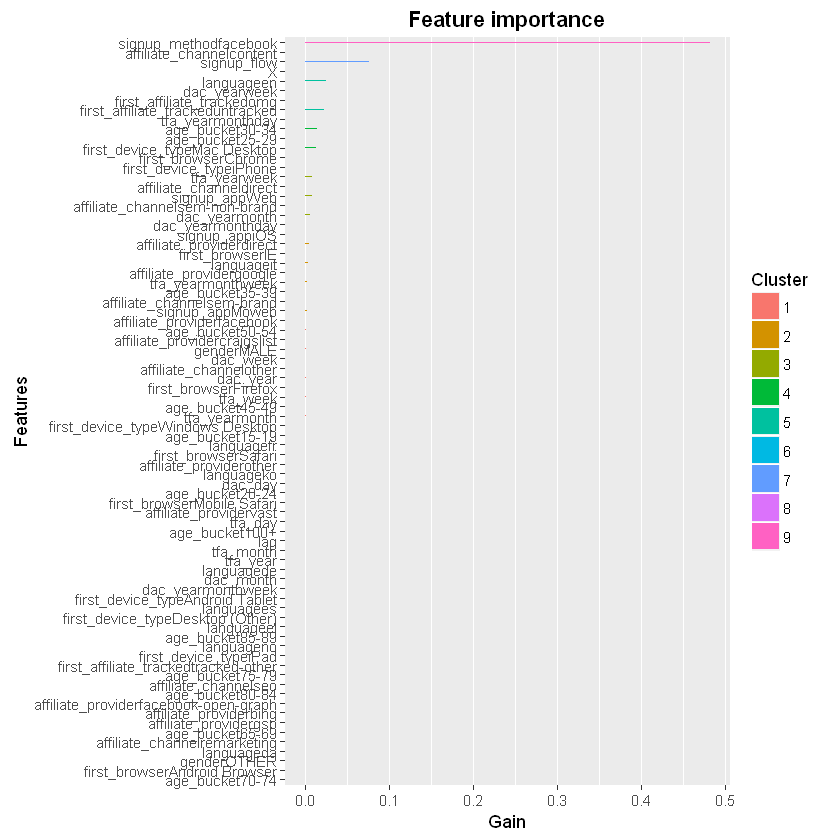

In [21]:
# Evaluating importance of features to the model
importance <- xgb.importance(sparse_tr@Dimnames[[2]], 
                              model = xgb$finalModel, 
                              data = sparse_tr, 
                              label = as.numeric(tr$country_destination)
                             )
 xgb.plot.importance(importance_matrix = importance)

In [22]:
str(xgb$finalModel)
xgb$results$Kappa

List of 6
 $ handle     :Class 'xgb.Booster.handle' <externalptr> 
 $ raw        : raw [1:114764] 00 00 00 3f ...
 $ xNames     : chr [1:165] "X" "age_bucket0-4" "age_bucket100+" "age_bucket15-19" ...
 $ problemType: chr "Classification"
 $ tuneValue  :'data.frame':	1 obs. of  6 variables:
  ..$ nrounds         : num 10
  ..$ max_depth       : num 4
  ..$ eta             : num 0.005
  ..$ gamma           : num 1
  ..$ colsample_bytree: num 0.3
  ..$ min_child_weight: num 1
 $ obsLevels  : chr [1:12] "AU" "CA" "DE" "ES" ...
 - attr(*, "class")= chr "xgb.Booster"


[1] 0.06308979 0.07668163 0.04594331 0.06665365 0.05909107 0.03541897
 [7] 0.08532833 0.10204172 0.06926877 0.07553982 0.06387066 0.06127646

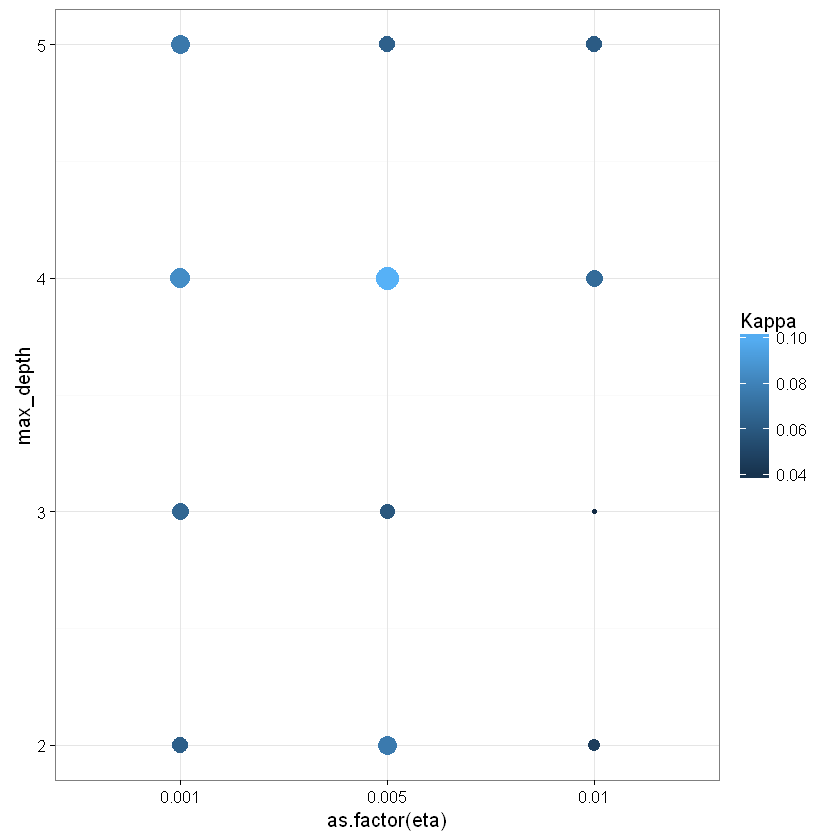

In [23]:
# scatter plot of the Kappa against max_depth and eta
ggplot(xgb$results, aes(x = as.factor(eta), y = max_depth, size = Kappa, color = Kappa)) + 
    geom_point() + 
    theme_bw() + 
    scale_size_continuous(guide = "none")

# Predictions
We use the "predictions" function to evaluate our model on both the training set and set set. We see from the below that the probabilities lead to NDF and US always being predicted. The accuracy at this point is also quite low. 

In [24]:
source("Predictions.R")
pred <- predictions(xgb$finalModel, sparse_dat, dat_raw$dataset, dat$country_destination)

pred$pred_tr %>% table()
pred$acc_tr

pred$pred_ts %>% table()
pred$acc_ts

.
  NDF    US 
75852  3885 

[1] 0.4877786

.
  NDF    US 
24990  1375 

[1] 0.4876162

## Submission
https://www.kaggle.com/indradenbakker/airbnb-recruiting-new-user-bookings/rscript-0-86547/discussion  
As per the example script above this submission file currently just takes the top 5 predictions in order as its submission file.

In [25]:
# Generate predictions on competition test set. 
# compare prediction to results
source("Generate_submission.R")
sparse_test <- sparse_dat[dat_raw$dataset == "test_external",]
id <- as.character(dat_raw[dat_raw$dataset == "test_external", "id"])

str(sparse_test)
final <- submission(xgb$finalModel, sparse_test, id, paste0("xgb", NAME))

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:712680] 0 1 2 3 4 5 6 7 8 9 ...
  ..@ p       : int [1:166] 0 27767 27767 27949 28585 32308 39767 45598 49050 51079 ...
  ..@ Dim     : int [1:2] 27767 165
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:27767] "106103" "106104" "106105" "106106" ...
  .. ..$ : chr [1:165] "X" "age_bucket0-4" "age_bucket100+" "age_bucket15-19" ...
  ..@ x       : num [1:712680] 213452 213457 213458 213463 213464 ...
  ..@ factors : list()


In [26]:
str(final)
nrow(sparse_tr)

List of 2
 $ df  :'data.frame':	27767 obs. of  6 variables:
  ..$ V1: Factor w/ 1 level "NDF": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:27767] "V1" "V2" "V3" "V4" ...
  ..$ V2: Factor w/ 1 level "US": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:27767] "V1" "V2" "V3" "V4" ...
  ..$ V3: Factor w/ 4 levels "ES","FR","GB",..: 4 4 4 4 4 4 4 4 4 4 ...
  .. ..- attr(*, "names")= chr [1:27767] "V1" "V2" "V3" "V4" ...
  ..$ V4: Factor w/ 6 levels "CA","ES","FR",..: 2 2 2 2 2 2 2 2 2 2 ...
  .. ..- attr(*, "names")= chr [1:27767] "V1" "V2" "V3" "V4" ...
  ..$ V5: Factor w/ 7 levels "CA","ES","FR",..: 3 3 3 3 3 3 3 3 3 3 ...
  .. ..- attr(*, "names")= chr [1:27767] "V1" "V2" "V3" "V4" ...
  ..$ id: chr [1:27767] "5uwns89zht" "szx28ujmhf" "guenkfjcbq" "fyomoivygn" ...
 $ file:'data.frame':	138835 obs. of  2 variables:
  ..$ id     : Factor w/ 27767 levels "0031awlkjq","0057snrdpu",..: 4446 4446 4446 4446 4446 22340 22340 22340 22340 22340 ...
  ..$ country: Factor w/

[1] 79737